In [3]:
## UTIL

import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from PIL import Image
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision
import json

In [5]:
import torch
from transformers import SamModel, SamProcessor
from segment_anything import SamPredictor, sam_model_registry

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter(log_dir="./logs")

sam_version = "b"

if (sam_version == "l"):
	model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

	sam = sam_model_registry["vit_l"](checkpoint="./model/sam_vit_l_0b3195.pth")
	print("Using sam_vit_large")
else: 
	model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
	processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

	sam = sam_model_registry["vit_b"](checkpoint="./model/sam_vit_b_01ec64.pth")
	print("Using sam_vit_base")
 
sam.to(device=device)
predictor = SamPredictor(sam)

Using sam_vit_base


In [6]:
# Loss Definition

import torch.nn.functional as F 

def compute_loss(pred_masks, true_masks, pred_scores, true_scores):

  mask_loss = F.binary_cross_entropy_with_logits(pred_masks, true_masks)
  score_loss = F.mse_loss(pred_scores, true_scores)
  
  return mask_loss + score_loss

In [ ]:
# Add images and masks to array

import os

panos_dirs = []
masks_dirs = []

training_dir = "./data/training/"
training_folder = ["0000", "0001"]

for item in training_folder:
  panos_dirs.append(training_dir + item + "/cropped_panos")
  masks_dirs.append(training_dir + item + "/cropped_masks")

image_paths = []
mask_paths = []

for i in range(len(panos_dirs)):
	for filename in os.listdir(panos_dirs[i]):
		if filename.endswith((".jpg", ".png")):
			image_path = os.path.join(panos_dirs[i], filename)
			mask_name = f"{os.path.splitext(filename)[0]}.json" 
			mask_path = os.path.join(masks_dirs[i], mask_name)

			if os.path.exists(mask_path):
					image_paths.append(image_path)
					mask_paths.append(mask_path)
			else:
					print(f"No mask for {image_path} found")

print(f"Amount of images found: {len(image_paths)}")
print(f"Amount of masks found: {len(mask_paths)}")


Amount of images found: 360
Amount of masks found: 360


In [ ]:
# Dataset definition

class WindowSegmentationDataset(Dataset):
	def __init__(self, image_paths, mask_paths, transform=None):
		self.image_paths = image_paths
		self.mask_paths = mask_paths
		self.transform = transform
	
	def __len__(self):
		return len(self.image_paths)
	
	def load_mask_from_json(self, json_path, image_size):
		with open(json_path, 'r') as f:
			data = json.load(f)
			
		mask = np.zeros(image_size, dtype=np.uint8)
		
		for shape in data['shapes']:
			points = np.array(shape['points'], dtype=np.int32)
			cv2.fillPoly(mask, [points], 1)
			
		mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
		return mask
			
	def __getitem__(self, idx):
		image = Image.open(self.image_paths[idx]).convert("RGB")
		json_path = self.mask_paths[idx]
		
		if (self.transform):
			image = self.transform(image)
   
		image_size = (image.shape[1], image.shape[2])
		mask = self.load_mask_from_json(json_path, image_size)
			
		return image, mask

transform = transforms.Compose([
	transforms.Resize((250, 250)),
 	transforms.ToTensor(),
])

dataset = WindowSegmentationDataset(image_paths, mask_paths, transform=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

In [ ]:
# Training

model.train()
optimizer = Adam(model.parameters(), lr=1e-4)

losses = []
accumulation_steps = 16

for epoch in range(10): 
	counter = 0
	running_loss = 0.0
	for i, (images, masks) in enumerate(data_loader):
		images, masks = images.to(device), masks.to(device)
		counter += 1
  
		inputs = processor(images, return_tensors="pt", do_rescale=False).to(device)
		image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
		outputs = model(**inputs)

		pred_masks = outputs.pred_masks

		# Choose best mask 
		scores = outputs.iou_scores.squeeze().tolist()
		max_index = scores.index(max(scores))
		best_mask = pred_masks[:, :, max_index]
 
		# Scale ground truth masks
		true_masks_resized = F.interpolate(masks, size=(256, 256), mode="bilinear", align_corners=False)
		true_masks_resized = (true_masks_resized > 0.5).float()

		# Loss calculation
		mask_loss = F.binary_cross_entropy_with_logits(best_mask, true_masks_resized)
		mask_loss = mask_loss / accumulation_steps
  
		losses.append(mask_loss.item())
		mask_loss.backward()
		running_loss += mask_loss.item()
  
		# Logging
		if i % 10 == 0:
			writer.add_scalar("Training loss", mask_loss.item(), epoch * len(data_loader) + i)
  
		#Backpropagation
		if (i + 1) % accumulation_steps == 0:
			optimizer.step()
			optimizer.zero_grad()
			writer.add_scalar("Epoch loss", running_loss / len(data_loader), epoch)
			running_loss = 0.0
  
		torch.cuda.empty_cache()
  
  # Display interim results
	if epoch % 2 == 0:
		img = inputs['pixel_values']
		img_grid = torchvision.utils.make_grid(img[:4])
		writer.add_image("Input Images", img_grid, epoch)
  
		mask = outputs.pred_masks.squeeze(0)
		mask = mask[0]
		mask_grid = torchvision.utils.make_grid(mask[:4])
		writer.add_image("Predicted Masks", mask_grid, epoch)
 
	# Leftover steps
	if (i + 1) % accumulation_steps != 0:
		optimizer.step()
		optimizer.zero_grad()
  
  
	print(f"Epoch: {epoch}")


Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9


In [24]:
running_loss

0.0

In [ ]:
# After training is done
torch.save(model.state_dict(), "./model/model_weights_base.pth")

In [14]:
# Initialize the model (same architecture)
model = SamModel.from_pretrained("facebook/sam-vit-large").to(device)

# Load the saved model weights
model.load_state_dict(torch.load("model_weights.pth"))

SamModel.save_pretrained(model, "sam_save")

# Set the model to evaluation mode if you're doing inference
model.eval()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-23): 24 x SamVisionLayer(
        (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (layer_norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1024, out_features=4096, bias=True)
          (lin2): Linear(in_features=4096, out_features=1024, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [ ]:

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

img_url = "./data/training/0000/panos/floor_01_partial_room_01_pano_15.jpg"
raw_image = cv2.imread(img_url)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)


AttributeError: 'SamModel' object has no attribute 'image_encoder'

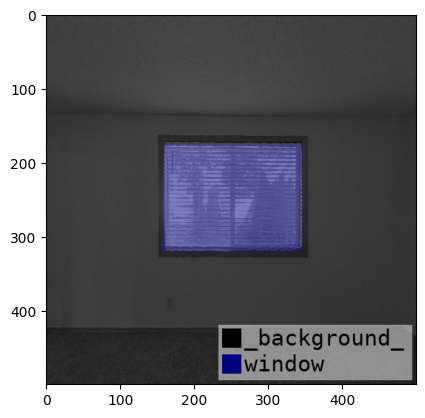

In [4]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("data/training/0000/cropped_panos/front_floor_01_partial_room_11_pano_25/label_viz.png")
plt.imshow(img)

(409, 204)


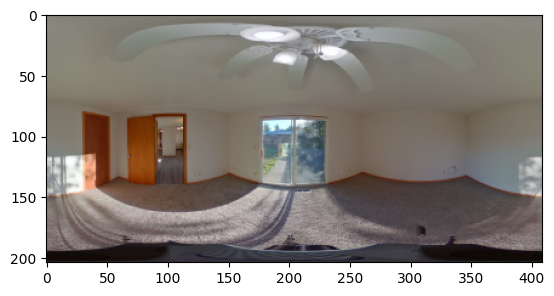

In [10]:
img_url = "./data/training/0000/panos/floor_01_partial_room_01_pano_15.jpg"
raw_image = cv2.imread(img_url)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
height, width = raw_image.shape[:2]
new_size = (width // 5, height // 5)
scaled_image = cv2.resize(raw_image, new_size, interpolation=cv2.INTER_AREA)
print(new_size)
plt.imshow(scaled_image)

In [11]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Bildvorbereitung
transform = transforms.Compose([
    transforms.ToTensor(),  # Umwandlung in Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard-Normalisierung
])

# Wir müssen das Bild skalieren und dann durch den Transformationsprozess schicken
input_image = transform(scaled_image).unsqueeze(0).to(device)  # Bild und Batch-Dimension hinzufügen

# Inferenz mit dem SAM-Modell
with torch.no_grad():
    output_mask = model(input_image)  # Hier benötigst du eventuell den spezifischen Inferenzcode für SAM

# Verarbeite die Ausgabe - Angenommen, die Ausgabe ist eine Maske
output_mask = output_mask.squeeze().cpu().numpy()  # Entferne Batch-Dimension und wandle in numpy-Array um

# Visualisiere die Maske
plt.imshow(output_mask, cmap='gray')  # Grayscale Maske anzeigen
plt.title("Segmentation Mask")
plt.show()


ValueError: Input image size (204*409) doesn't match model (1024*1024).

In [ ]:
inputs = processor(raw_image, input_boxes=input_boxes, return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
  outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

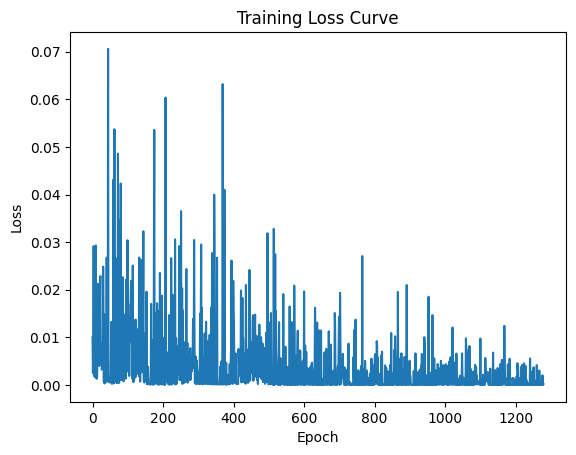

[0.010012466460466385, 0.0025432403199374676, 0.008030629716813564, 0.029165776446461678, 0.0018989047966897488, 0.008330730721354485, 0.0020055826753377914, 0.005413752514868975, 0.001556099159643054, 0.029298309236764908, 0.008977878838777542, 0.006651804782450199, 0.0012922758469358087, 0.0018336010398343205, 0.00960436463356018, 0.015373914502561092, 0.021241458132863045, 0.010246947407722473, 0.007680542767047882, 0.003995093517005444, 0.007155832834541798, 0.017614426091313362, 0.022884009405970573, 0.005270252004265785, 0.006737302988767624, 0.00872864481061697, 0.0032133888453245163, 0.0034761386923491955, 0.003690732177346945, 0.004175984766334295, 0.02484801411628723, 0.01146834995597601, 0.0006326516158878803, 0.014875832013785839, 0.00030152779072523117, 0.001053743064403534, 0.002293582074344158, 0.0006087357178330421, 0.0005900976830162108, 0.00416884571313858, 0.026754092425107956, 0.0008448085281997919, 0.01964852213859558, 0.0008613310055807233, 0.07059356570243835, 0.

In [25]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()
print(losses)

Text(0.5, 1.0, 'Original Image')

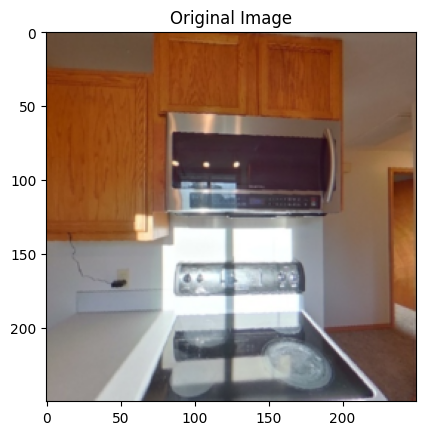

In [28]:
plt.imshow(images[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Original Image")

Text(0.5, 1.0, 'Mask')

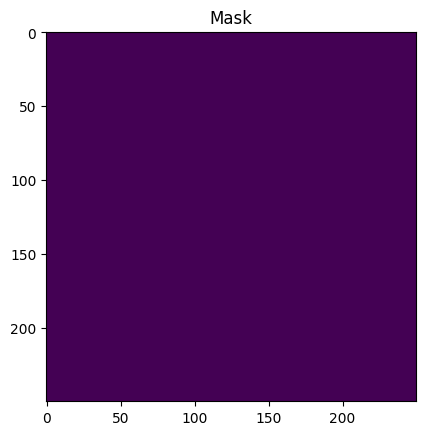

In [29]:
plt.imshow(masks[0].cpu().permute(1, 2, 0))  # Original image
plt.title("Mask")